# **<span style="color: #87CEEB;"> CS437/CS5317/EE414/EE513 Deep Learning Programming Assignment 2</span>**

# <span style="color: #9370DB;">**Submission Guidelines**</span>

- <span style="color: #9370DB;">Please rename the file to `<RollNumber>_PA1_1`.</span>
- <span style="color: #9370DB;">Please also submit a **.py** file of every Notebook. You can do this by exporting your **ipynb** to a Python script.</span>
- <span style="color: #9370DB;">Please submit a zipped folder of both your Jupyter Notebooks and Python script files.</span>






```
# This is formatted as code
```

### Name: Basil
### Roll Number: 26100303

In [1]:
# ============ Necessary libraries have been imported for you aleadry =============
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
%matplotlib inline
import kagglehub
import cv2
import tensorflow as tf

'''
You may include more libraries, if you want to
'''

'\nYou may include more libraries, if you want to\n'

In [2]:
# BATCH_SIZE = # DEFINE YOUR BATCH SIZE HERE

<hr>

## <h1><b> Part 3: Autoencoder for image segmentation <span style="color: #9370DB;"> (50 Points Total)</span></b></h1>  

<hr>

This task involves segmenting brain tumors from MRI scans using an autoencoder. The goal is to train a model that can accurately segment tumors, indicated by binary masks, from MRI images. Your model should be symmetrical, and input-output resolutions must remain consistent, achieved via appropriate padding.

### **Task 1: Dataset Prep**
- You'll be using `brain-tumor-segmentation` dataset (you can access it from [here](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation?resource=download))
- You may download it locally or use it's kaggle link. In either case, make sure you have an `image` and a `mask` directory containing the images and the masks respectively for the brain tumor.
- The dataset consists of `3065` PNGs with dimensions `512x512`.

In [3]:
# Uncomment below lines ONLY if you're using Colab
!pip install kaggle --upgrade
from google.colab import files

# Upload kaggle.json manually or ensure it's in your drive
# files.upload()

# # Move kaggle.json to the correct location
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation --unzip -p /content/

brain_tumor_segmentation_path = "/content/"
print(brain_tumor_segmentation_path)

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 99% 309M/312M [00:08<00:00, 37.0MB/s]
100% 312M/312M [00:08<00:00, 36.7MB/s]
/content/


In [4]:
import glob

# Set the dataset path
dataset_path = "/content/images"

# Count total images (adjust extensions if needed)
image_files = glob.glob(os.path.join(dataset_path, "**", "*.png"), recursive=True)  # Change "*.png" if images are in JPG or other formats
print(f"Total images loaded: {len(image_files)}")

Total images loaded: 3064


In [5]:
image_dir = "/content/images"
ground_truths_dir = "/content/masks"

IMG_SIZE = (256, 256)  # Ensure this is defined

def preprocessing(image, mask):
    '''
    The purpose of this function is to apply necessary preprocessing steps to both the input images
    and their corresponding ground truth masks before they are used for model training.
    '''
    # Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert RGB/BGR to Grayscale

    # Resize image and mask
    image = cv2.resize(image, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)

    # Normalize image to [0,1] range
    image = image / 255.0

    # Convert mask to binary (if needed) and normalize
    mask = mask / 255.0
    mask = np.where(mask > 0.5, 1, 0)  # Ensure mask is binary

    # Expand dimensions to match expected shape (H, W) → (H, W, 1)
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # Convert to TensorFlow tensors
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)

    return image, mask

In [6]:
# Load images and ground truths


'''
1. Load all image files and the corresponding ground truth mask files from their respective directories.
2. Read the images and masks and apply pre-processing (if any).
3. Append the preprocessed images to the `data` list and the corresponding masks to the `ground_truths`
   list (both list have initialized above).

Make sure each image correctly corresponds to its mask.
'''
# ============ Your code here ============= #

data = []
ground_truths = []

# Get sorted list of image and mask filenames to ensure correct pairing
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(ground_truths_dir))

# Function to load and preprocess images and masks
def load_data():
    for img_name, mask_name in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(ground_truths_dir, mask_name)

        # Read image and mask
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as color
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

        # Apply preprocessing
        preprocessed_image, preprocessed_mask = preprocessing(image, mask)

        # Append to lists
        data.append(preprocessed_image)
        ground_truths.append(preprocessed_mask)

# Load data
load_data()

# Convert lists to NumPy arrays if needed
data = np.array(data)
ground_truths = np.array(ground_truths)

print(f"Total images loaded: {len(data)}")
print(f"Total masks loaded: {len(ground_truths)}")


Total images loaded: 3064
Total masks loaded: 3064


In [19]:
'''
1. Create a train-val-test split using DataLoader (ideally 70% test, 20% val, and 10% test
   would be okay but upto you to come up with your own split composition).
2. You may use train_test_split() function (imported above) for splitting, but if you're
   comfortable with split strategies, that's totally fine.
3. Once splitted, use DataLoader class to load the datasets.
'''

# Print number of images in each set

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

# Define batch size
BATCH_SIZE = 32

# Convert data & ground_truths lists to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format
ground_truths_tensor = torch.tensor(ground_truths, dtype=torch.float32).permute(0, 3, 1, 2)

# Custom dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

# Create dataset
dataset = BrainTumorDataset(data_tensor, ground_truths_tensor)

# Train-Validation-Test Split (70% train, 20% val, 10% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total sum matches

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print number of images in each set


print(f"train batches: {len(train_loader)*BATCH_SIZE} ({len(train_loader)/3065*BATCH_SIZE*100}%)")
print(f"val batches: {len(val_loader)*BATCH_SIZE} ({len(val_loader)/3065*BATCH_SIZE*100}%)")
print(f"test batches: {len(test_loader)} ({len(test_loader)/3065*100}%)")

# you may define your own variable names for loaders (names used above are just samples)

train batches: 2144 (69.9510603588907%)
val batches: 640 (20.880913539967374%)
test batches: 10 (0.3262642740619902%)


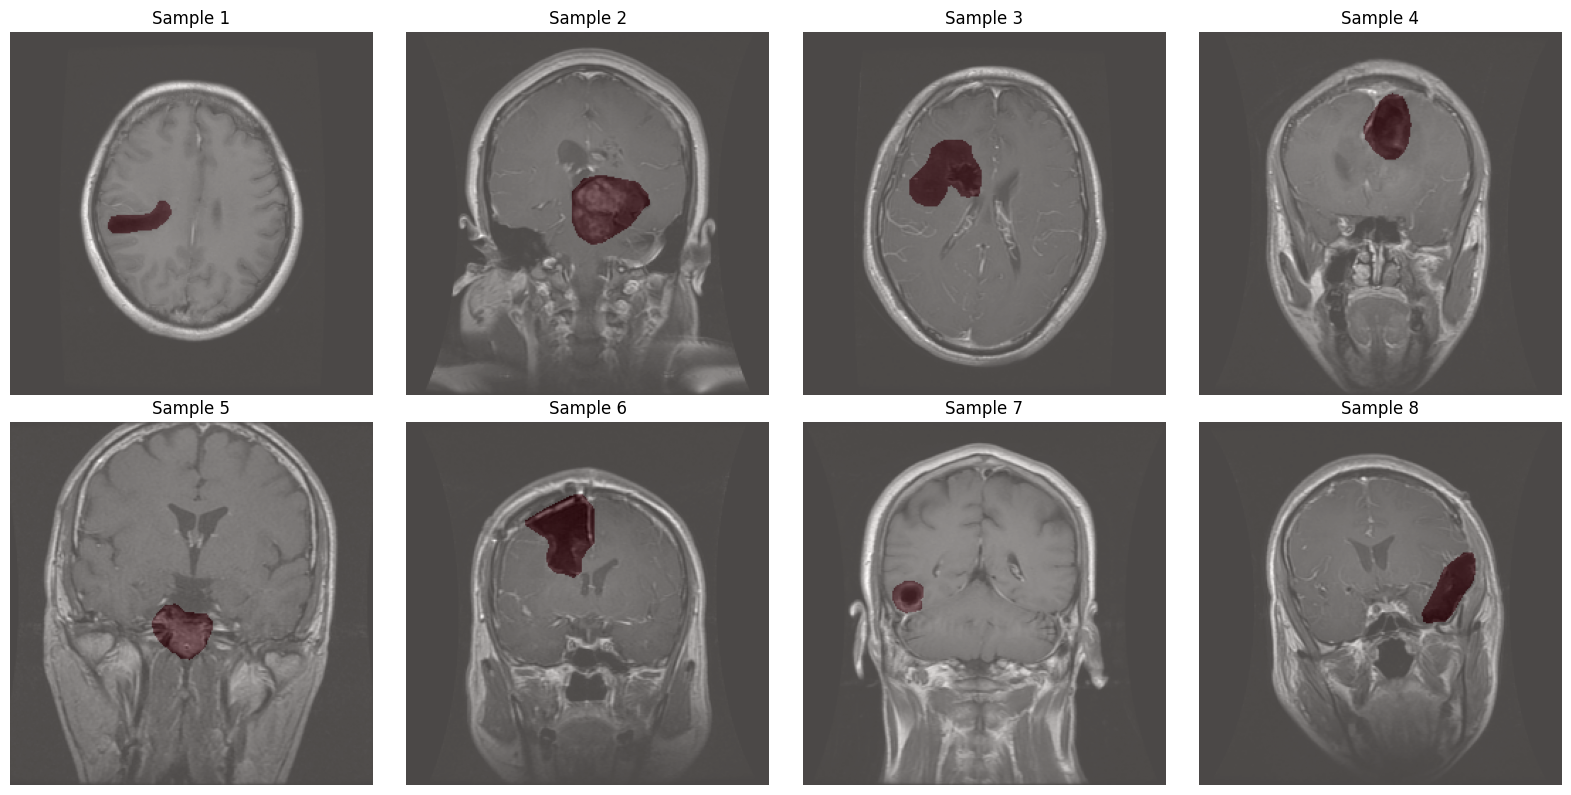

In [8]:
'''
Once you're done making the dataset, use the function below to vizualize it.
'''

def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        mask = mask.squeeze(0).numpy()  # Convert from (1, H, W) to (H, W)

        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(image, cmap='gray')  # Display image
        ax.imshow(mask, alpha=0.3, cmap='Reds')  # Overlay mask
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()


# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_dataset), 8, replace=False)
random_samples = [(train_dataset[i][0], train_dataset[i][1]) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

# Visualize
visualize_samples(random_images, random_masks)


### **Task 2: Implement the Dice Loss Function**  
In segmentation tasks, using MSE loss is often ineffective due to class imbalance, especially when the region of interest (e.g., brain tumors) is small. Hence, you are going to implement the Dice Loss by creating a custom `DiceLoss` class. Dice Loss is more suitable for segmentation tasks as it directly measures overlap between predictions and ground truth.  

Given:  
- **Predicted mask:** \( p \)  
- **Ground truth:** \( t \)  
- **Smoothing factor:** \( s \) (prevents division by zero)  

#### $L = 1 - \frac{2 \cdot \sum(p \cdot t) + s}{\sum(p^{2}) + \sum(t^{2}) + s}$

The smoothing factor $s$ is a small value (usually of the order of $1e^{-6}$).
For more details, see [this paper](https://arxiv.org/pdf/1606.04797.pdf) (page 6).  


In [9]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-6

    def forward(self, prediction, target):
        # Flatten predictions and targets
        prediction = prediction.contiguous().view(-1)
        target = target.contiguous().view(-1)
        # Compute intersection and sums
        intersection = (prediction * target).sum()
        numerator = 2. * intersection + self.smooth
        denominator = prediction.pow(2).sum() + target.pow(2).sum() + self.smooth
        dice_loss = 1 - (numerator / denominator)
        return dice_loss

### **Task 3: Define Autoencoder for Brain Tumor segmentation**


In [10]:
class SegmentationAE(nn.Module):
    def __init__(self):
        super(SegmentationAE, self).__init__()

        # --- Encoder ---
        self.enc1 = self.conv_block(1, 32)         # 256x256 -> 256x256
        self.pool1 = nn.MaxPool2d(2, 2)              # 256x256 -> 128x128

        self.enc2 = self.conv_block(32, 64)          # 128x128 -> 128x128
        self.pool2 = nn.MaxPool2d(2, 2)              # 128x128 -> 64x64

        self.enc3 = self.conv_block(64, 128)         # 64x64 -> 64x64
        self.pool3 = nn.MaxPool2d(2, 2)              # 64x64 -> 32x32

        self.enc4 = self.conv_block(128, 256)        # 32x32 -> 32x32
        self.pool4 = nn.MaxPool2d(2, 2)              # 32x32 -> 16x16

        # --- Bottleneck ---
        self.bottleneck = self.conv_block(256, 512)  # 16x16

        # --- Decoder ---
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 16x16 -> 32x32
        self.dec4 = self.conv_block(256 + 256, 256)  # concatenate with enc4

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 32x32 -> 64x64
        self.dec3 = self.conv_block(128 + 128, 128)  # concatenate with enc3

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 64x64 -> 128x128
        self.dec2 = self.conv_block(64 + 64, 64)     # concatenate with enc2

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)    # 128x128 -> 256x256
        self.dec1 = self.conv_block(32 + 32, 32)     # concatenate with enc1

        self.conv_final = nn.Conv2d(32, 1, kernel_size=1)
        self.activation = nn.Sigmoid()  # To constrain output to (0,1)

    def conv_block(self, in_channels, out_channels):
        """Helper function: Two conv layers with BatchNorm and ReLU."""
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)                    # (B, 32, 256, 256)
        enc2 = self.enc2(self.pool1(enc1))       # (B, 64, 128, 128)
        enc3 = self.enc3(self.pool2(enc2))       # (B, 128, 64, 64)
        enc4 = self.enc4(self.pool3(enc3))       # (B, 256, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))  # (B, 512, 16, 16)

        # Decoder path with skip connections
        dec4 = self.upconv4(bottleneck)          # (B, 256, 32, 32)
        dec4 = torch.cat((dec4, enc4), dim=1)      # (B, 256+256, 32, 32)
        dec4 = self.dec4(dec4)                   # (B, 256, 32, 32)

        dec3 = self.upconv3(dec4)                # (B, 128, 64, 64)
        dec3 = torch.cat((dec3, enc3), dim=1)      # (B, 128+128, 64, 64)
        dec3 = self.dec3(dec3)                   # (B, 128, 64, 64)

        dec2 = self.upconv2(dec3)                # (B, 64, 128, 128)
        dec2 = torch.cat((dec2, enc2), dim=1)      # (B, 64+64, 128, 128)
        dec2 = self.dec2(dec2)                   # (B, 64, 128, 128)

        dec1 = self.upconv1(dec2)                # (B, 32, 256, 256)
        dec1 = torch.cat((dec1, enc1), dim=1)      # (B, 32+32, 256, 256)
        dec1 = self.dec1(dec1)                   # (B, 32, 256, 256)

        out = self.conv_final(dec1)              # (B, 1, 256, 256)
        out = self.activation(out)
        return out

# Instantiate and print summary
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationAE().to(device)
from torchsummary import summary
summary(model, input_size=(1, 256, 256), batch_size=BATCH_SIZE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 256, 256]             320
       BatchNorm2d-2          [8, 32, 256, 256]              64
              ReLU-3          [8, 32, 256, 256]               0
            Conv2d-4          [8, 32, 256, 256]           9,248
       BatchNorm2d-5          [8, 32, 256, 256]              64
              ReLU-6          [8, 32, 256, 256]               0
         MaxPool2d-7          [8, 32, 128, 128]               0
            Conv2d-8          [8, 64, 128, 128]          18,496
       BatchNorm2d-9          [8, 64, 128, 128]             128
             ReLU-10          [8, 64, 128, 128]               0
           Conv2d-11          [8, 64, 128, 128]          36,928
      BatchNorm2d-12          [8, 64, 128, 128]             128
             ReLU-13          [8, 64, 128, 128]               0
        MaxPool2d-14            [8, 64,

### **Task 4: Define the Training Loop**  

- Print both the training and validation losses for each epoch.  
- Plot the training and validation loss curves, with epochs on the x-axis and losses on the y-axis, at the end of the training.  
- Save the best model as a `.pth` file using the `torch.save()` method. **Submit this file along with your notebook, naming it as `campus_id.pth`.**  
- After every 2ish epochs, visualize a grid displaying the Image | Ground Truth Mask | Predicted Mask.


Epoch [1/20] - Train Loss: 0.7867, Val Loss: 0.8978
Epoch [2/20] - Train Loss: 0.5307, Val Loss: 0.9006


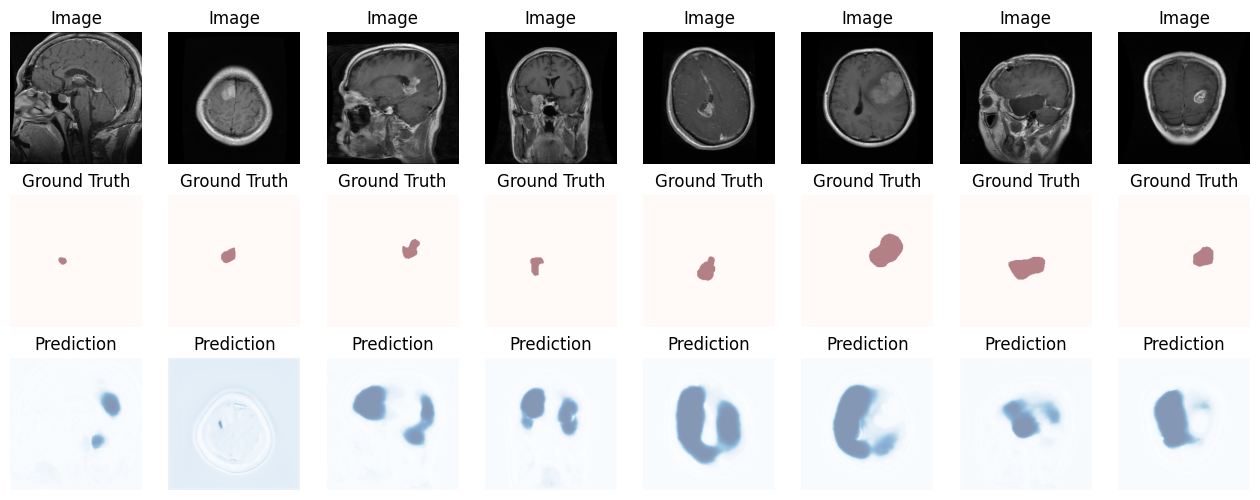

Epoch [3/20] - Train Loss: 0.3832, Val Loss: 0.3905
Epoch [4/20] - Train Loss: 0.3159, Val Loss: 0.3209


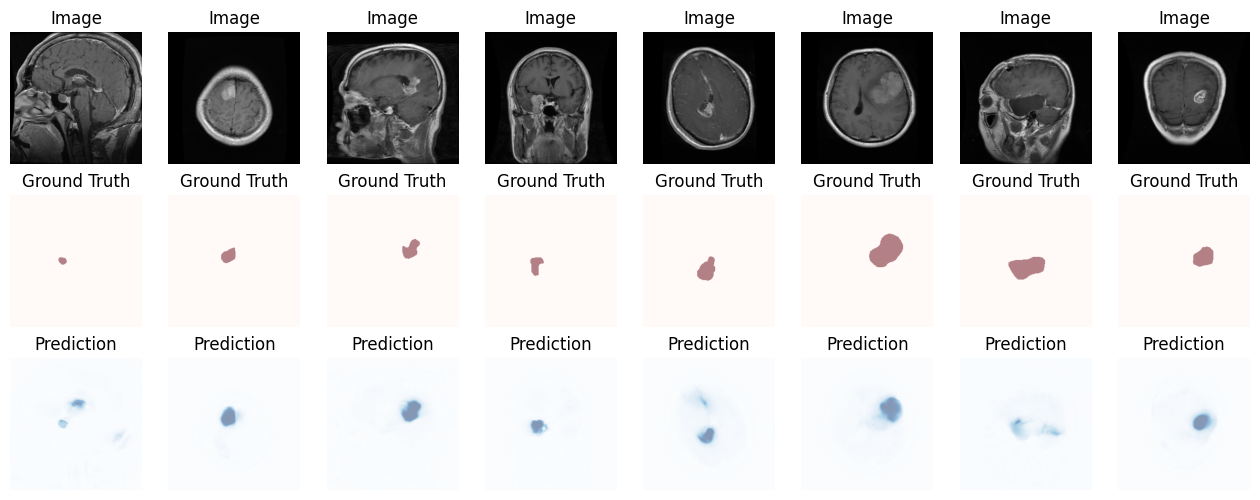

Epoch [5/20] - Train Loss: 0.2674, Val Loss: 0.4679
Epoch [6/20] - Train Loss: 0.2383, Val Loss: 0.3667


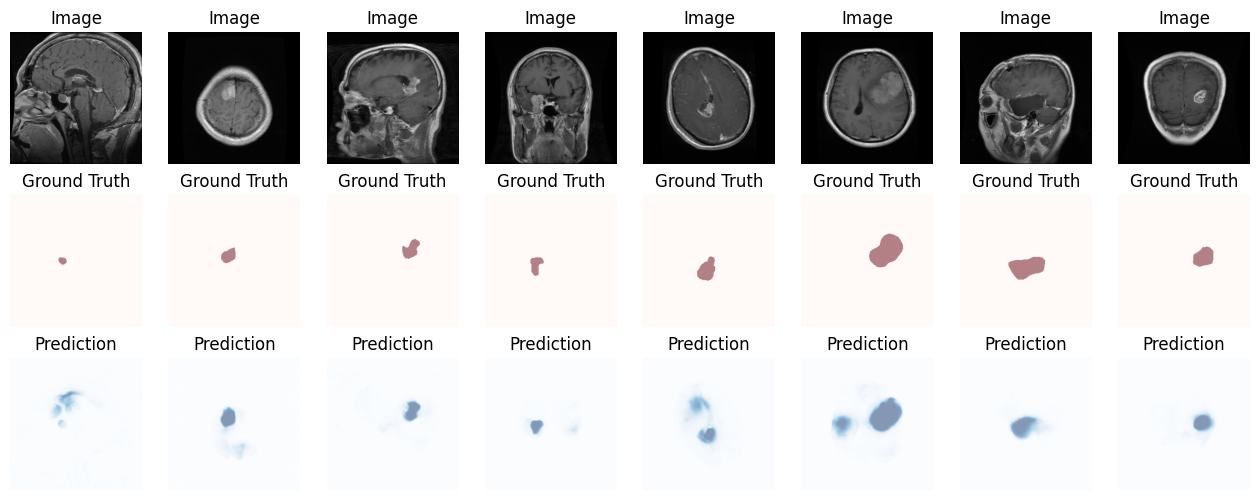

Epoch [7/20] - Train Loss: 0.2185, Val Loss: 0.3283
Epoch [8/20] - Train Loss: 0.1932, Val Loss: 0.2364


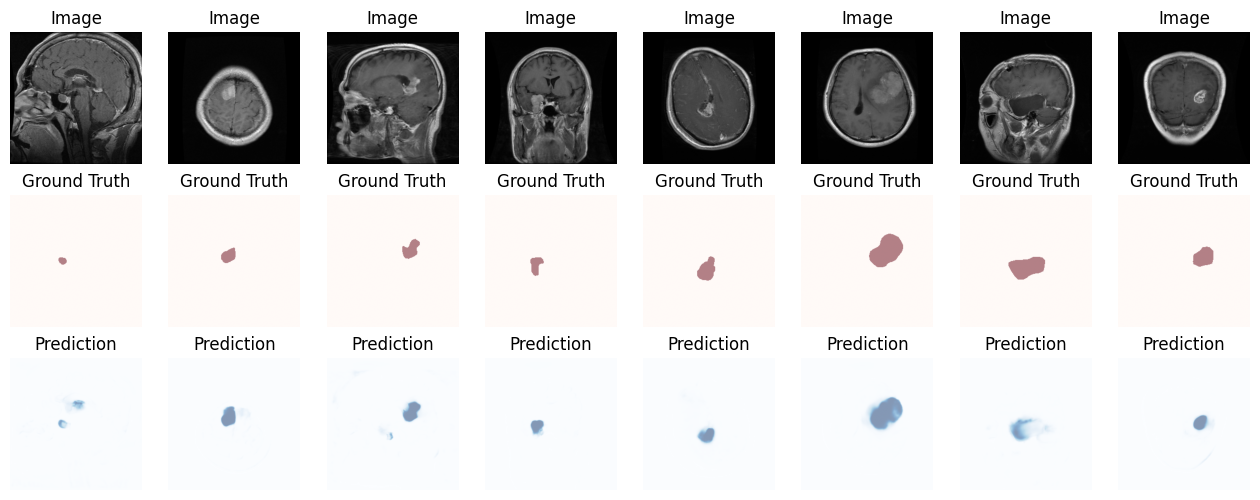

Epoch [9/20] - Train Loss: 0.1743, Val Loss: 0.2395
Epoch [10/20] - Train Loss: 0.1670, Val Loss: 0.2223


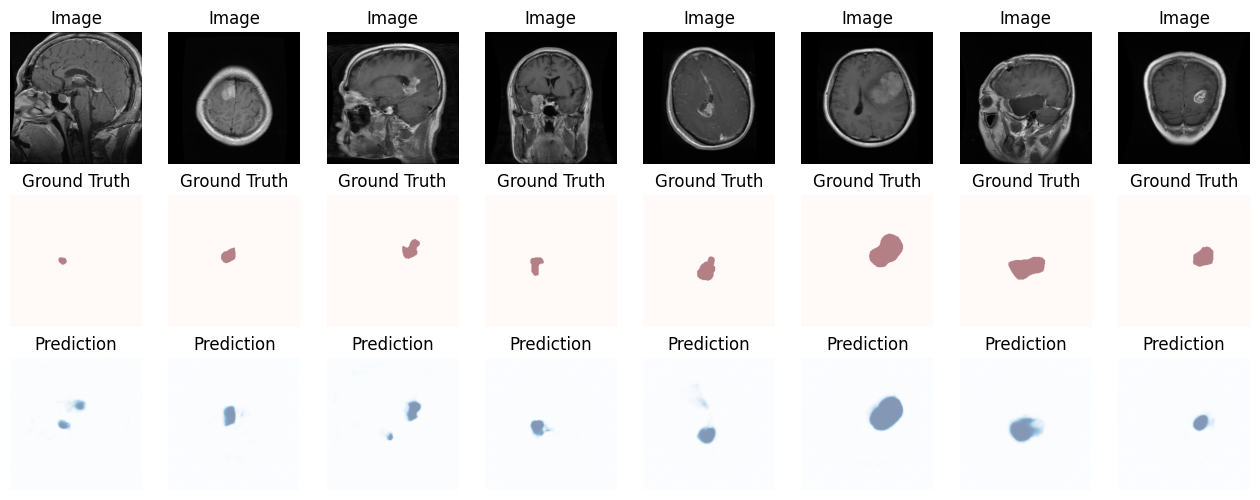

Epoch [11/20] - Train Loss: 0.1530, Val Loss: 0.2955
Epoch [12/20] - Train Loss: 0.1432, Val Loss: 0.1951


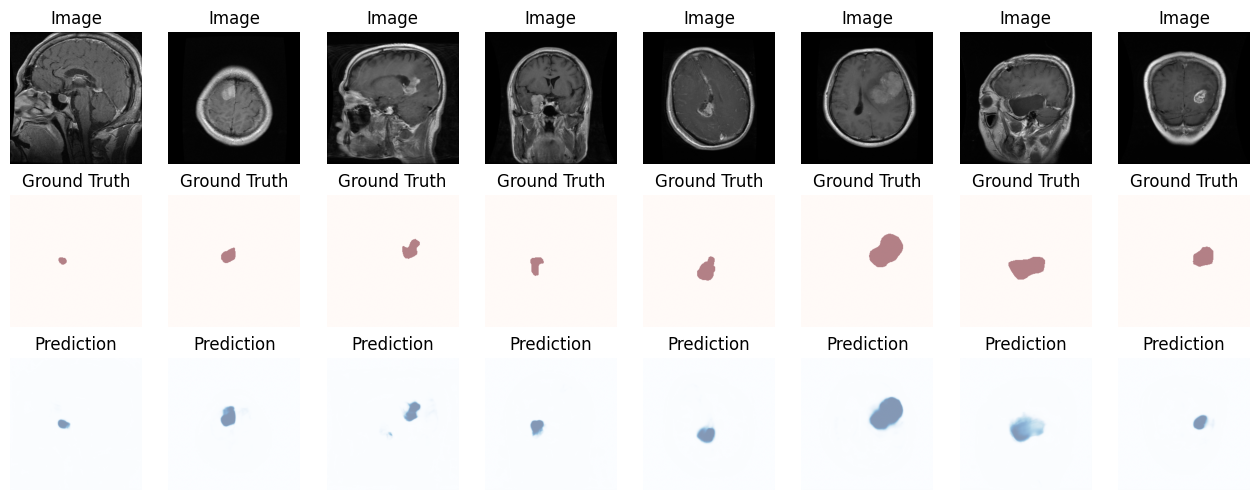

Epoch [13/20] - Train Loss: 0.1301, Val Loss: 0.1842
Epoch [14/20] - Train Loss: 0.1225, Val Loss: 0.2531


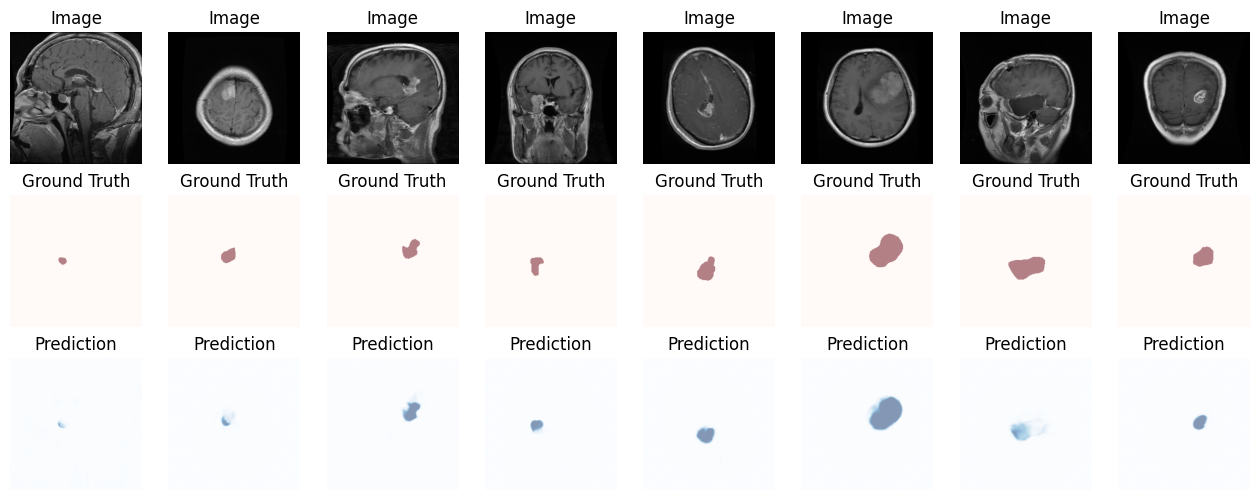

Epoch [15/20] - Train Loss: 0.1182, Val Loss: 0.1926
Epoch [16/20] - Train Loss: 0.1100, Val Loss: 0.1679


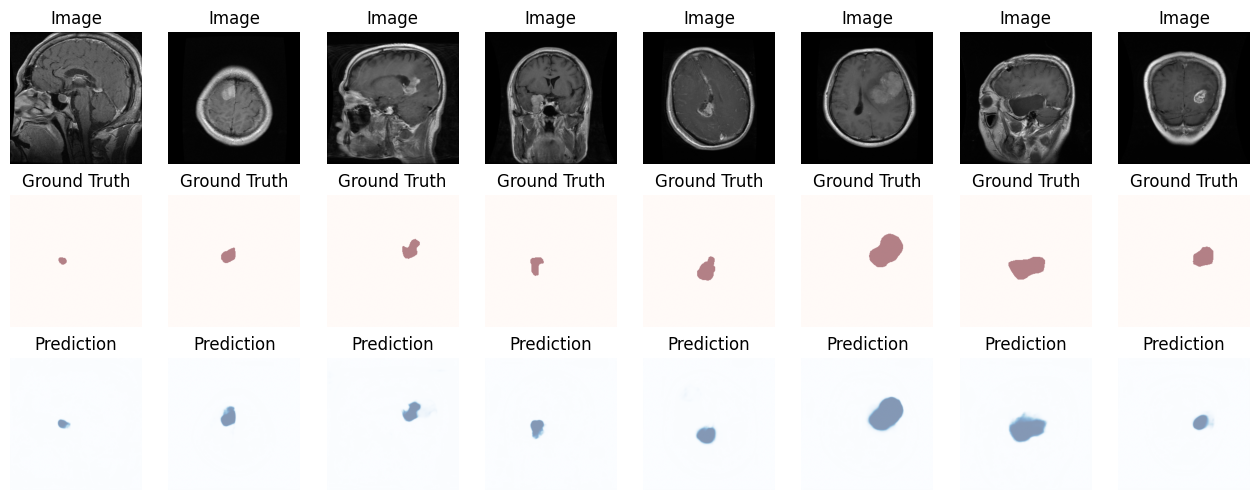

Epoch [17/20] - Train Loss: 0.1059, Val Loss: 0.1880
Epoch [18/20] - Train Loss: 0.1003, Val Loss: 0.1745


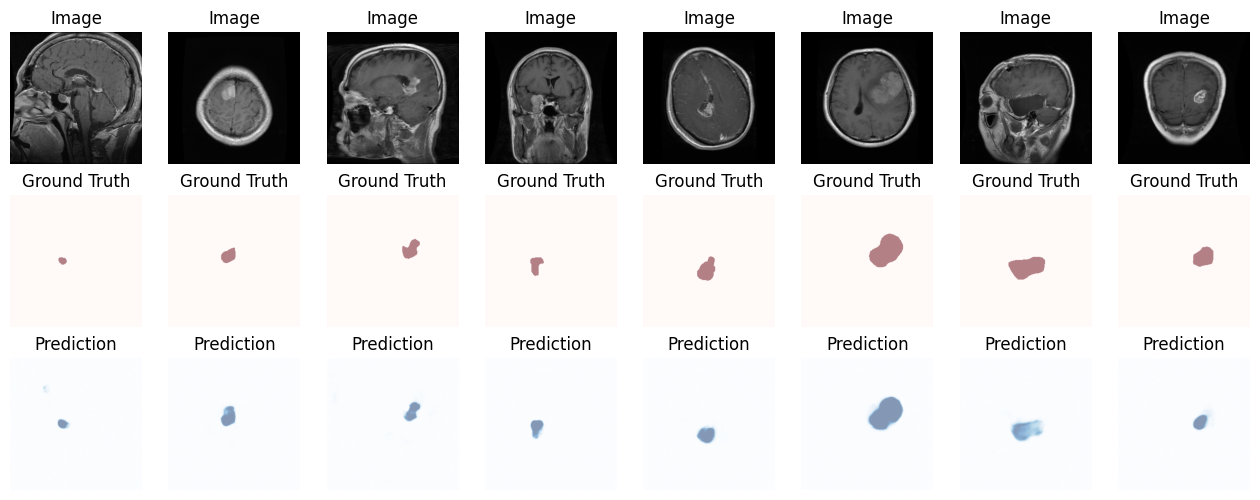

Epoch [19/20] - Train Loss: 0.0932, Val Loss: 0.1941
Epoch [20/20] - Train Loss: 0.0884, Val Loss: 0.1918


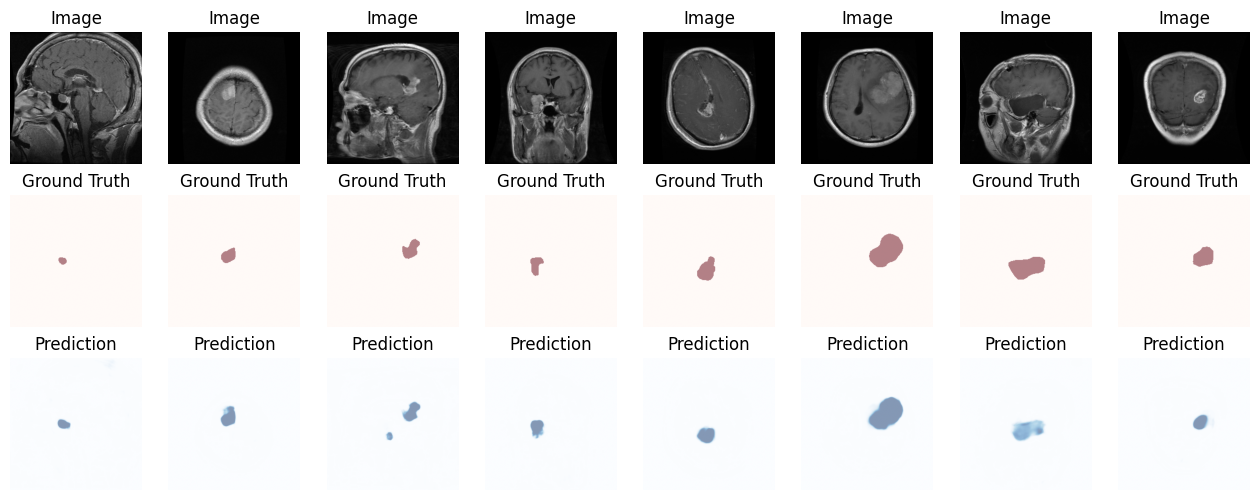

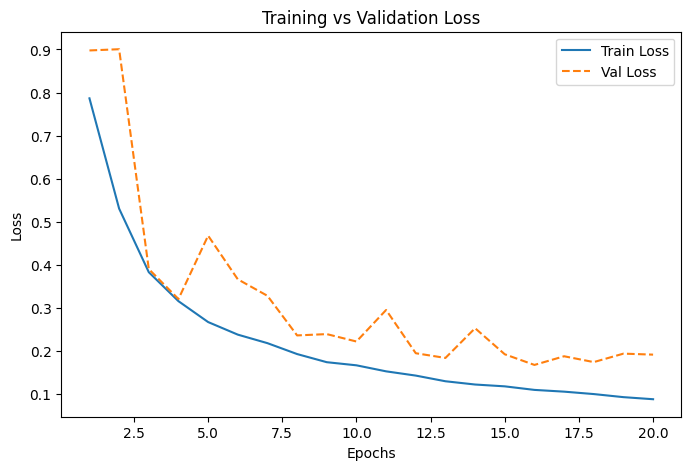

In [11]:
# ----------------------------
# 1. Setup: define criterion, optimizer, and number of epochs
# ----------------------------

LEARNING_RATE = 0.001

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
EPOCHS = 20 # add num of epochs you wanna run
# ============ Your code here ============= #

# Set up training parameters
  # Adjust based on available resources

BATCH_SIZE = 8
CHECKPOINT_PATH = "26100303.pth"


# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Track losses
train_losses, val_losses = [], []
best_val_loss = float('inf')

# --- TRAINING LOOP ---
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # --- VALIDATION LOOP ---
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # --- IMAGE VISUALIZATION EVERY 2 EPOCHS ---
    if (epoch + 1) % 2 == 0:
        model.eval()
        images, masks = next(iter(val_loader))  # Take a batch from validation set
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            preds = model(images)

        # Convert to numpy for visualization
        images_np = images.cpu().numpy().squeeze(1)
        masks_np = masks.cpu().numpy().squeeze(1)
        preds_np = preds.cpu().numpy().squeeze(1)

        fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(16, 6))
        for i in range(8):
            axes[0, i].imshow(images_np[i], cmap='gray')
            axes[0, i].set_title("Image")
            axes[1, i].imshow(masks_np[i], cmap='Reds', alpha=0.5)
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(preds_np[i], cmap='Blues', alpha=0.5)
            axes[2, i].set_title("Prediction")

            for ax in axes[:, i]:
                ax.axis('off')

        plt.show()

# --- PLOT TRAINING & VALIDATION LOSS ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss", linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



### **Task 5: Evaluate Your Autoencoder's Segmentation**  

- Select and visualize **10 random samples** from the test set, displaying the **Image | Ground Truth Mask | Predicted Mask** in a grid format.  
- Compute the **Dice Coefficient** and **Intersection over Union (IoU)** scores for the entire test dataset.  

#### **Mathematical Expressions:**  
- **Dice Coefficient (DICE):**  $\text{DICE} = \frac{2 \times \sum(p \cup t)}{\sum(p) + \sum(t)}$

- **Intersection over Union (IoU):**  $\text{IoU} = \frac{\sum(p \cup t)}{\sum(p \cap t)}$

Where:  
- $p$ = Predicted mask (binary)  
- $t$ = Ground truth mask (binary)  

Make sure to print the computed scores.

In [17]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = (2 * intersect) / total_sum if total_sum > 0 else 1.0
    return dice

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou_value = intersect / union if union > 0 else 1.0
    return iou_value

<ipython-input-20-4031e6a83196>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))


Average Dice Coefficient on Test Set: 0.8095
Average IoU on Test Set: 0.7215


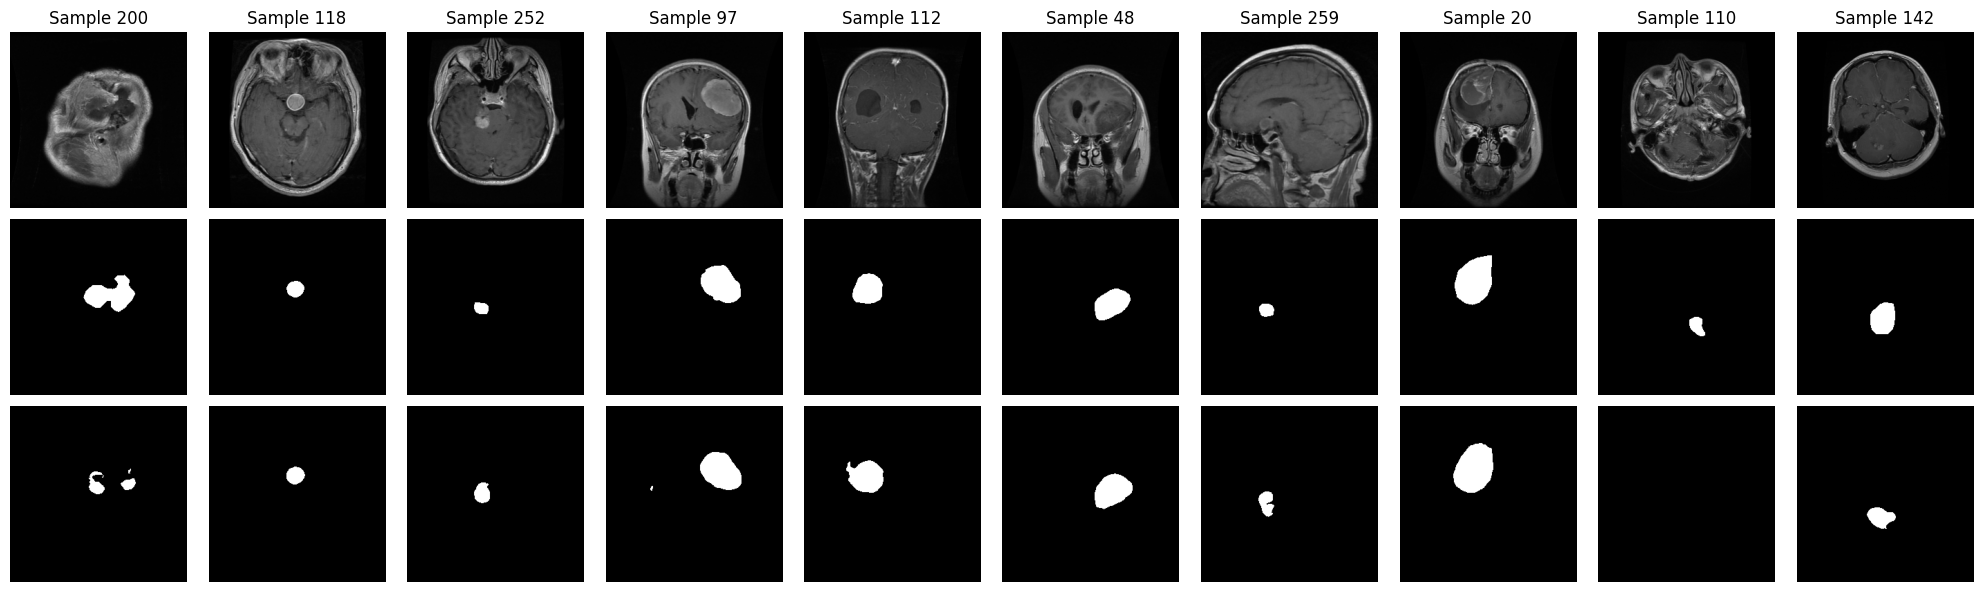

In [20]:
# Load model checkpoint

import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.to(device)
model.eval()

all_dice = []
all_iou = []
all_images = []
all_ground_truths = []
all_predictions = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()

        for i in range(images.size(0)):
            gt_np = masks[i].cpu().numpy()
            pred_np = preds[i].cpu().numpy()
            # Append metrics
            all_dice.append(dice_coef(gt_np, pred_np))
            all_iou.append(iou(gt_np, pred_np))
            # Append images and masks for visualization
            all_images.append(images[i].cpu().numpy())
            all_ground_truths.append(gt_np)
            all_predictions.append(pred_np)


# Compute average metrics
avg_dice = np.mean(all_dice)
avg_iou = np.mean(all_iou)

print(f"Average Dice Coefficient on Test Set: {avg_dice:.4f}")
print(f"Average IoU on Test Set: {avg_iou:.4f}")

# Visualization of 10 random samples
num_samples_to_show = 10
rand_indices = random.sample(range(len(all_images)), num_samples_to_show)

fig, axes = plt.subplots(nrows=3, ncols=num_samples_to_show, figsize=(20, 6))
for idx, sample_idx in enumerate(rand_indices):
    image = np.squeeze(all_images[sample_idx])
    gt_mask = np.squeeze(all_ground_truths[sample_idx])
    pred_mask = np.squeeze(all_predictions[sample_idx])

    axes[0, idx].imshow(image, cmap='gray')
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f"Sample {sample_idx}")

    axes[1, idx].imshow(gt_mask, cmap='gray')
    axes[1, idx].axis('off')

    axes[2, idx].imshow(pred_mask, cmap='gray')
    axes[2, idx].axis('off')

axes[0, 0].set_ylabel("Image", fontsize=12)
axes[1, 0].set_ylabel("Ground Truth", fontsize=12)
axes[2, 0].set_ylabel("Prediction", fontsize=12)
plt.tight_layout()
plt.show()

## Submissions
- Notebook.
- Best model's `.pth` file. Rename it to `campus_id.pth`.